In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm, tqdm_notebook
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import os
import tensorflow as tf

from pathlib import Path

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed
TEST_PATH = '../../PennFudanPed/TEST/'
num_classes = 3

Using TensorFlow backend.


In [2]:
test_img_ids = next(os.walk(TEST_PATH + 'PNGImages'))[2]

In [3]:
coco_persons_img_path = '../../multimedia_datasets/person/' + 'images'
coco_persons_mask_path = '../../multimedia_datasets/person/' + 'masks'

coco_knifes_img_path = '../../multimedia_datasets/knife/' + 'images'
coco_knifes_mask_path = '../../multimedia_datasets/knife/' + 'masks'

coco_cars_img_path = '../../multimedia_datasets/car/' + 'images'
coco_cars_mask_path = '../../multimedia_datasets/car/' + 'masks'
'''
coco_mask_path = '../../coco_persons/' + 'masks'
train_coco_mask_ids = next(os.walk(coco_mask_path))[2]
'''

"\ncoco_mask_path = '../../coco_persons/' + 'masks'\ntrain_coco_mask_ids = next(os.walk(coco_mask_path))[2]\n"

In [4]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)
# Define IoU metric
def iou(y_true, y_pred):
    prec = []
    for t in [0.5]:
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [18]:
def load_coco_images(X_train, Y_train, image_path, mask_path, pos):
    print(image_path)
    idsy = next(os.walk(image_path))[2]
    for n, id_ in tqdm_notebook(enumerate(idsy), total=len(idsy)):
        if n%200==0:
            path = image_path + "/"
            path_masks = mask_path + "/"
            if Path(path+id_).exists and Path(path_masks + id_).exists:
                try:
                    img = imread(path+id_)[:,::IMG_CHANNELS]
                except IndexError as e:
                    print(e)
                    if Path(path+id_).exists:
                        os.remove(path+id_)

                    if Path(path_masks + id_).exists:    
                        os.remove(path_masks+id_)
                    continue

                img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                try:
                    X_train.append(img)
                except ValueError as v:
                    print(v)
                    if Path(path+id_).exists:
                        os.remove(path+id_)
                    if Path(path_masks + id_).exists: 
                        os.remove(path_masks+id_)
                    continue
                mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)



                
                mask = imread(path_masks+id_[:-4]+'.png')

                mask = resize(mask , (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                                  preserve_range=True)
                mask = np.expand_dims(mask, axis=2)
                mask = np.where(mask<0.0001, 0, 1)
                zero = np.zeros(mask.shape)
                #mask = np.ones(mask.shape)
                if pos == 0:
                    ext_mask = np.concatenate((mask, zero, zero), axis=2)
                elif pos == 1:
                    ext_mask = np.concatenate((zero, mask, zero), axis=2)
                else:
                    ext_mask = np.concatenate((zero, zero, mask), axis=2)
                Y_train.append(ext_mask)

In [19]:
# Get and resize train images and masks
#X_train_coco = np.zeros((len(train_coco_img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
#Y_train_coco = np.zeros((len(train_coco_img_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
X_train_persons, Y_train_persons = [], []
load_coco_images(X_train_persons, Y_train_persons, coco_persons_img_path+'/', coco_persons_mask_path, 0)
X_train_persons = np.asarray(X_train_persons, dtype=np.int32)
print(X_train_persons.shape)
Y_train_persons = np.asarray(Y_train_persons)
print(Y_train_persons.shape)

../../multimedia_datasets/person/images/



(276, 128, 128, 3)
(276, 128, 128, 3)


In [20]:
X_train_knifes, Y_train_knifes = [], []
load_coco_images(X_train_knifes, Y_train_knifes, coco_knifes_img_path, coco_knifes_mask_path, 1)
X_train_knifes = np.asarray(X_train_knifes, dtype=np.int32)
print(X_train_knifes.shape)
Y_train_knifes = np.asarray(Y_train_knifes)
print(Y_train_knifes.shape)

../../multimedia_datasets/knife/images



(10, 128, 128, 3)
(10, 128, 128, 3)


In [21]:
X_train_cars, Y_train_cars = [], []
load_coco_images(X_train_cars, Y_train_cars, coco_cars_img_path, coco_cars_mask_path, 2)
X_train_cars = np.asarray(X_train_cars, dtype=np.int32)
print(X_train_cars.shape)
Y_train_cars = np.asarray(Y_train_cars)
print(Y_train_cars.shape)

../../multimedia_datasets/car/images



(19, 128, 128, 3)
(19, 128, 128, 3)


In [22]:
X_train = np.concatenate((X_train_persons, X_train_knifes, X_train_cars), axis=0)
Y_train = np.concatenate((Y_train_persons, Y_train_knifes, Y_train_cars), axis=0)

In [23]:
# Get and resize test images
X_test = np.zeros((len(test_img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print(len(test_img_ids))
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_img_ids), total=len(test_img_ids)):
    path = TEST_PATH + 'PNGImages' + '/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

16
Getting and resizing test images ... 


100%|██████████| 16/16 [00:00<00:00, 127.35it/s]

Done!


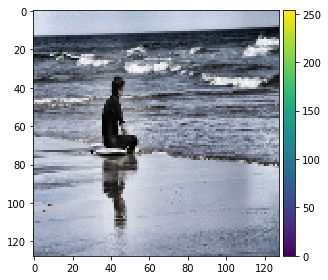

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


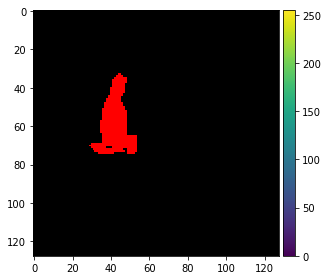

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


In [41]:

# Check if training data looks all right
ix = random.randint(0, len(X_train))
imshow(X_train[ix])
plt.show()
imshow(Y_train[ix]*255.0)
plt.show()
print(Y_train[ix])

In [42]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same', name="c1") (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same', name="c2") (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same', name="c3") (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same', name="c4") (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same', name="c5") (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name="u6") (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same', name="c6") (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same', name="c7") (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', name="u8") (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same', name="c8") (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same', name="u9") (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same', name="c9") (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(num_classes, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou,iou])
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
c1 (Conv2D

In [43]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [44]:
import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="logs/",histogram_freq=1,
                            write_graph=False, write_images=False)

In [45]:
# Fit model
earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('../../modele/test.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=50, 
                    callbacks=[earlystopper, checkpointer, tensorboard])

Train on 274 samples, validate on 31 samples
Epoch 1/50
274/274 [==============================] - 4s 16ms/step - loss: 0.2843 - mean_iou: 0.4513 - iou: 0.4423 - val_loss: 0.3497 - val_mean_iou: 0.4786 - val_iou: 0.5042

Epoch 00001: val_loss improved from inf to 0.34974, saving model to ../../modele/test.h5
Epoch 2/50
274/274 [==============================] - 1s 4ms/step - loss: 0.1981 - mean_iou: 0.4845 - iou: 0.5228 - val_loss: 0.3966 - val_mean_iou: 0.4868 - val_iou: 0.5324

Epoch 00002: val_loss did not improve from 0.34974
Epoch 3/50
274/274 [==============================] - 1s 4ms/step - loss: 0.1986 - mean_iou: 0.4875 - iou: 0.5371 - val_loss: 0.3862 - val_mean_iou: 0.4893 - val_iou: 0.5429

Epoch 00003: val_loss did not improve from 0.34974
Epoch 4/50
274/274 [==============================] - 1s 4ms/step - loss: 0.1825 - mean_iou: 0.4909 - iou: 0.5479 - val_loss: 0.3737 - val_mean_iou: 0.4917 - val_iou: 0.5522

Epoch 00004: val_loss did not improve from 0.34974
Epoch 00004:

In [46]:


# Predict on train, val and test
model = load_model('../../modele/test.h5', custom_objects={'mean_iou': mean_iou,'iou': iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))
    
# Perform a sanity check on some random training samples




16/16 [==============================] - 0s 5ms/step


ON TRAINING DATA
int32
(128, 128, 3)


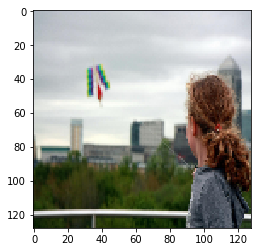

In [47]:
print("ON TRAINING DATA")
ix = random.randint(0, len(preds_train_t))
print(X_train[ix].dtype )
print(X_train[ix].shape)
plt.imshow(X_train[ix]);  plt.show(); 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


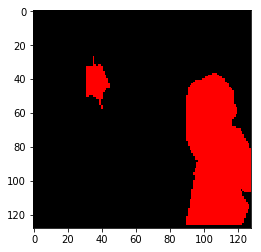

In [48]:
plt.imshow(Y_train[ix]*255) ;  plt.show(); 

(array([ 43,  47,  47,  47,  47,  47,  48,  48,  49,  49,  49,  50,  50,
        51,  51,  51,  51,  51,  51,  51,  51,  51,  51,  52,  52,  52,
        53,  53,  53,  54,  54,  54,  54,  54,  55,  55,  55,  55,  55,
        55,  55,  55,  55,  56,  56,  56,  56,  57,  57,  57,  57,  58,
        58,  58,  58,  58,  59,  59,  59,  59,  59,  59,  59,  59,  59,
        59,  59,  60,  60,  60,  60,  60,  61,  61,  61,  61,  61,  61,
        61,  61,  61,  61,  62,  62,  62,  62,  62,  62,  62,  62,  62,
        62,  62,  62,  63,  63,  63,  63,  63,  63,  63,  63,  63,  63,
        63,  63,  63,  63,  63,  63,  63,  63,  64,  64,  64,  64,  64,
        64,  64,  64,  64,  64,  65,  65,  65,  65,  65,  65,  65,  65,
        65,  65,  66,  66,  66,  66,  66,  66,  66,  66,  66,  66,  66,
        66,  67,  67,  67,  67,  67,  67,  67,  67,  67,  67,  67,  67,
        67,  67,  67,  67,  67,  68,  68,  68,  68,  68,  68,  68,  68,
        68,  68,  69,  69,  69,  69,  69,  69,  69,  69,  69,  

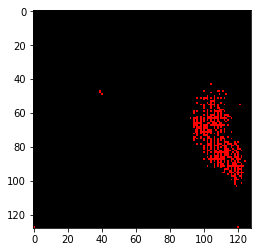

In [49]:
a = preds_train_t[ix]*255.0
a = a.astype(np.int32)
print(np.where(preds_train_t[ix]>0.0))
plt.imshow(a) ;

ON VALIDATION


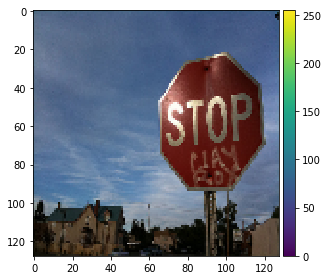

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


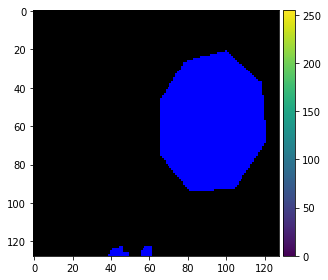

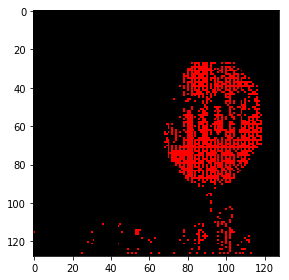

In [50]:
print("ON VALIDATION")
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix]) ; plt.show() ;
imshow(Y_train[int(Y_train.shape[0]*0.9):][ix]*255) ; plt.show() ; 
imshow(preds_val_t[ix]*255) ; plt.show() ; 
# Perform a sanity check on some random test samples

ON RANDOM TEST


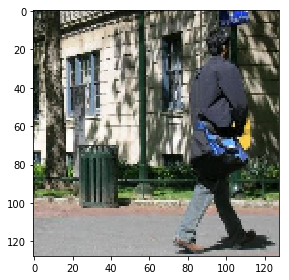

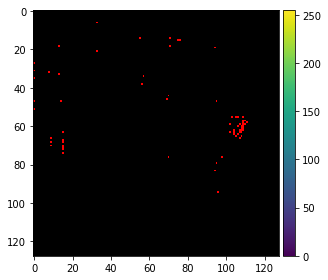

In [53]:
print("ON RANDOM TEST")
ix = random.randint(0, len(preds_test_t)-1)

imshow(X_test[ix]) ; plt.show(); 
imshow(preds_test_t[ix]*255) ; plt.show() ; 